# 루브릭
|평가문항|상세기준|self check|
|:-------|:-------|:-----------------------|
|1. 주어진 영화 코퍼스를 바탕으로 워드임베딩 모델을 정상적으로 만들었다.|워드임베딩의 most_similar() 메소드 결과가 의미상 바르게 나왔다.|OK|
|2. 영화 구분, 장르별로 target, attribute에 대한 대표성있는 단어 셋을 생성하였다.|타당한 방법론을 통해 중복이 잘 제거되고 개념축을 의미적으로 잘 대표하는 단어 셋이 만들어졌다.|OK|
|3. WEAT score 계산 및 시각화를 정상적으로 진행하였다.|전체 영화 장르별로 예술/일반 영화에 대한 편향성 WEAT score가 상식에 부합하는 수치로 얻어졌으며 이를 잘 시각화하였다.|OK|

### dataset
1.영화 시놉시스 코퍼스 

### 적용할 알고리즘
1. Word2Vec

### 평가 지표  
1. WEAT score

## 문제 정의  

> 영화 구분과 모든 영화 장르간에 내재된 편향성 측정

## 분석 결과  
 **1. 사람의 편향과 반대**
 
|예술영화|일반영화|편향|weat score|
|:---------:|:----------:|:----------:|:--:|
|사극|SF|반대|-0.83 |
|드라마|기타|반대|-0.85 |
|멜로로맨스|기타|반대| -0.87|
|사극|기타|반대|-0.80 |
|성인물|기타|반대|-0.88 |
|드라마|다큐멘터리|반대|-0.87 |
|멜레로맨스|타큐멘터리|반대|-0.87 |
|사극|다큐멘터리|반대|-0.81 |
|성인물|다큐멘터리|반대|-0.92 |
|에드밴처|다큐멘터리|반대|-0.86 |
|판타지|드라마|반대|-0.82 |
|멜로로맨스|판타지|반대|-0.97 |
|스릴러|범죄|반대|0.98 |
|애니메이션|애미메이션|반대|-0.87 |
  
<hr/>

 **2. 사람의 편향과 같음** 
 
|예술영화|일반영화|편향|weat score|
|:---------:|:----------:|:----------:|:--:|
|가족|다큐멘터리|같음|0.80 |
|가족|애니메니션|같음|0.83 |
|공연|기타|같음| 0.90|
|공연|다큐멘터리|같음|0.90 |
|공연|뮤지컬|같음|0.86 |
|공연|애니메이션|같음|0.89 |
|드라마|매니메이션|같음|0.85 |
|멜로로맨스|뮤지컬|같음|0.83 |
|멜로로맨스|범죄|같음|0.83 |
|멜로로맨스|애니메이션|같음|0.85 |
|멜로로맨스|코미디|같음|0.89 |
|멜로로맨스|판타지|같음|0.82 |
|미스터리|범죄|같음|0.98 |
|사극|애미메이션|같음|0.82 |
|사극|전쟁|같음|0.85 |


## 분석환경

In [61]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import Image
#Image(filename='test.jpg') 

In [2]:
import konlpy
import gensim
import sklearn
import seaborn

print(konlpy.__version__)
print(gensim.__version__)
print(sklearn.__version__)
print(seaborn.__version__)

0.5.2
4.1.2
1.0
0.11.2


## 6-4. WEAT 구현하기

In [3]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

* targets  
  * X set(꽃) : 장미, 튤립, 백합, 데이지
  * Y set(곤충) : 거미, 모기, 파리, 메뚜기
* attributes
  * A set(유쾌) : 사랑, 행복, 웃음
  * B set(불쾌) : 재난, 고통, 증오

#### word embedding 결과

In [4]:
target_X = {
    '장미': [4.1, 1.2, -2.4, 0.5, 4.1],
    '튤립': [3.1, 0.5, 3.6, 1.7, 5.8],
    '백합': [2.9, -1.3, 0.4, 1.1, 3.7],
    '데이지': [5.4, 2.5, 4.6, -1.0, 3.6]
}
target_Y = {
    '거미': [-1.5, 0.2, -0.6, -4.6, -5.3],
    '모기': [0.4, 0.7, -1.9, -4.5, -2.9],
    '파리': [0.9, 1.4, -2.3, -3.9, -4.7],
    '메뚜기': [0.7, 0.9, -0.4, -4.1, -3.9]
}
attribute_A = {
    '사랑':[2.8,  4.2, 4.3,  0.3, 5.0],
    '행복':[3.8,  3. , -1.2,  4.4, 4.9],
    '웃음':[3.7, -0.3,  1.2, -2.5, 3.9]
}
attribute_B = {
    '재난': [-0.2, -2.8, -4.7, -4.3, -4.7],
    '고통': [-4.5, -2.1,  -3.8, -3.6, -3.1],
    '증오': [-3.6, -3.3, -3.5,  -3.7, -4.4]
}


In [5]:
X = np.array([v for v in target_X.values()])
Y = np.array([v for v in target_Y.values()])
print(X)
print(Y)

A = np.array([v for v in attribute_A.values()])
B = np.array([v for v in attribute_B.values()])
print(A)
print(B)

[[ 4.1  1.2 -2.4  0.5  4.1]
 [ 3.1  0.5  3.6  1.7  5.8]
 [ 2.9 -1.3  0.4  1.1  3.7]
 [ 5.4  2.5  4.6 -1.   3.6]]
[[-1.5  0.2 -0.6 -4.6 -5.3]
 [ 0.4  0.7 -1.9 -4.5 -2.9]
 [ 0.9  1.4 -2.3 -3.9 -4.7]
 [ 0.7  0.9 -0.4 -4.1 -3.9]]
[[ 2.8  4.2  4.3  0.3  5. ]
 [ 3.8  3.  -1.2  4.4  4.9]
 [ 3.7 -0.3  1.2 -2.5  3.9]]
[[-0.2 -2.8 -4.7 -4.3 -4.7]
 [-4.5 -2.1 -3.8 -3.6 -3.1]
 [-3.6 -3.3 -3.5 -3.7 -4.4]]


#### s(w,A,B) 함수

* 양수 : attribute A에 더 가깝다.
* 음수 : attribute B에 더 가깝다.

In [6]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b

* 양수이므로 target_X_장미는 attribute A(유쾌)에 가깝다
* 음수이므로 target_Y_거미는 attribute B(불쾌)에 가깝다

In [7]:
s(target_X['장미'], A, B)
s(target_Y['거미'], A, B)

0.6457646122337399

-0.794002342033094

* 양수이므로 target_X는 attribute A(유쾌)에 가깝다

In [8]:
print(s(X, A, B))
print(round(np.mean(s(X, A, B)), 3))

[0.29551989 0.51723181 0.26499096 0.50924109]
0.397


* 음수이므로 target_Y는 attribute B(불쾌)에 가깝다

In [9]:
print(s(Y, A, B))
print(round(np.mean(s(Y, A, B)), 3))

[-0.44713039 -0.28310853 -0.33144878 -0.26030641]
-0.33


#### WEAT score 함수

* -2 ~ 2 범위
* 절대값이 클 수록 편향이 심함

In [10]:
def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev


* Target_X (꽃)는 attribute_A(유쾌)한 단어와 상대적으로 가까움
* Target_Y (곤충)은 attribute_B(불쾌)한 단어와 상대적으로 가까움

In [11]:
print(round(weat_score(X, Y, A, B), 3))

1.932


* 파란색 점(attribute_A)
* 빨간색 점(attribute_B)
* 하늘색 점(Target_X)
* 분홍색 점(Target_Y)

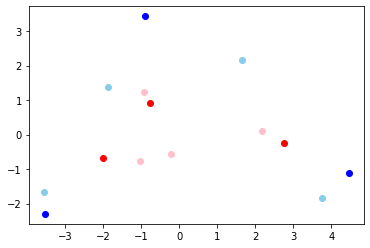

In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pc_A = pca.fit_transform(A)
pc_B = pca.fit_transform(B)
pc_X = pca.fit_transform(X)
pc_Y = pca.fit_transform(Y)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(pc_A[:,0],pc_A[:,1], c='blue', label='A')
ax.scatter(pc_B[:,0],pc_B[:,1], c='red', label='B')
ax.scatter(pc_X[:,0],pc_X[:,1], c='skyblue', label='X')
ax.scatter(pc_Y[:,0],pc_Y[:,1], c='pink', label='Y')

## 6-5. 사전학습된 Word Embedding에 WEAT 적용

In [13]:
import os

data_dir = '~/aiffel/weat' 
model_dir = os.path.join(data_dir, 'GoogleNews-vectors-negative300.bin')

from gensim.models import KeyedVectors

# 50만개의 단어만 활용합니다. 메모리가 충분하다면 limit 파라미터값을 생략하여 300만개를 모두 활용할 수 있습니다. 
w2v = KeyedVectors.load_word2vec_format(model_dir, binary=True, limit=500000)

In [14]:
w2v

In [15]:
# print(len(w2v.vocab))   # Gensim 3.X 버전까지는 w2v.vocab을 직접 접근할 수 있습니다. 
print(len(w2v.index_to_key))   # Gensim 4.0부터는 index_to_key를 활용해 vocab size를 알 수 있습니다. 
print(len(w2v['I']))                    # 혹은 단어를 key로 직접 vector를 얻을 수 있습니다. 
print(w2v.vectors.shape)

500000
300
(500000, 300)


In [16]:
w2v['happy']


array([-5.18798828e-04,  1.60156250e-01,  1.60980225e-03,  2.53906250e-02,
        9.91210938e-02, -8.59375000e-02,  3.24218750e-01, -2.17285156e-02,
        1.34765625e-01,  1.10351562e-01, -1.04980469e-01, -2.90527344e-02,
       -2.38037109e-02, -4.02832031e-02, -3.68652344e-02,  2.32421875e-01,
        3.20312500e-01,  1.01074219e-01,  5.83496094e-02, -2.91824341e-04,
       -3.29589844e-02,  2.11914062e-01,  4.32128906e-02, -8.59375000e-02,
        2.81250000e-01, -1.78222656e-02,  3.79943848e-03, -1.71875000e-01,
        2.06054688e-01, -1.85546875e-01,  3.73535156e-02, -1.21459961e-02,
        2.04101562e-01, -3.80859375e-02,  3.61328125e-02, -8.15429688e-02,
        8.44726562e-02,  9.37500000e-02,  1.44531250e-01,  7.42187500e-02,
        2.51953125e-01, -7.91015625e-02,  8.69140625e-02,  1.58691406e-02,
        1.09375000e-01, -2.23632812e-01, -5.15747070e-03,  1.68945312e-01,
       -1.36718750e-01, -2.51464844e-02, -3.85742188e-02, -1.33056641e-02,
        1.38671875e-01,  

In [17]:
w2v.most_similar(positive=['happy'])
w2v.most_similar(positive=['family'])
w2v.most_similar(positive=['school'])

[('glad', 0.7408890724182129),
 ('pleased', 0.6632170677185059),
 ('ecstatic', 0.6626912355422974),
 ('overjoyed', 0.6599286794662476),
 ('thrilled', 0.6514049172401428),
 ('satisfied', 0.6437949538230896),
 ('proud', 0.636042058467865),
 ('delighted', 0.627237856388092),
 ('disappointed', 0.6269949674606323),
 ('excited', 0.6247665286064148)]

[('relatives', 0.6662653088569641),
 ('familiy', 0.6517067551612854),
 ('families', 0.6252894997596741),
 ('siblings', 0.6140849590301514),
 ('friends', 0.6128394603729248),
 ('mother', 0.6065612435340881),
 ('aunt', 0.5811319947242737),
 ('grandparents', 0.5762072205543518),
 ('father', 0.5717043876647949),
 ('Family', 0.5672314763069153)]

[('elementary', 0.7868632078170776),
 ('schools', 0.7411909103393555),
 ('elementary_schools', 0.6597153544425964),
 ('kindergarten', 0.6529811024665833),
 ('eighth_grade', 0.6488089561462402),
 ('School', 0.6477997303009033),
 ('teacher', 0.63824063539505),
 ('students', 0.6301522850990295),
 ('classroom', 0.6281620264053345),
 ('Schools', 0.6172096133232117)]

#### WEAT를 통해 이 모델의 편향성을 확인

In [18]:
target_X = ['science', 'technology', 'physics', 'chemistry', 'Einstein', 'NASA', 'experiment', 'astronomy']
target_Y = ['poetry', 'art', 'Shakespeare', 'dance', 'literature', 'novel', 'symphony', 'drama']
attribute_A = ['brother', 'father', 'uncle', 'grandfather', 'son', 'he', 'his', 'him']
attribute_B = ['sister', 'mother', 'aunt', 'grandmother', 'daughter', 'she', 'hers', 'her']

X = np.array([w2v[word] for word in target_X])
Y = np.array([w2v[word] for word in target_Y])
A = np.array([w2v[word] for word in attribute_A])
B = np.array([w2v[word] for word in attribute_B])

weat_score(X, Y, A, B)

1.2624874

In [19]:
target_X = ['pizza', 'coke', 'hamburger', 'ham', 'ramen', 'icecream', 'candy']
target_Y = ['salad', 'fruit', 'vegetable', 'herb', 'root', 'greens', 'wholesome']
attribute_A = ['junk', 'canned', 'convenience', 'frozen', 'fast']
attribute_B = ['health', 'beneficial', 'good', 'nourishing', 'nutritious']

X = np.array([w2v[word] for word in target_X])
Y = np.array([w2v[word] for word in target_Y])
A = np.array([w2v[word] for word in attribute_A])
B = np.array([w2v[word] for word in attribute_B])

weat_score(X, Y, A, B)

1.6909266

In [20]:
target_X = ['pizza', 'coke', 'hamburger', 'ham', 'ramen', 'icecream', 'candy']
target_Y = ['salad', 'fruit', 'vegetable', 'herb', 'root', 'greens', 'wholesome']
attribute_A = ['book', 'essay', 'dictionary', 'magazine', 'novel']
attribute_B = ['news', 'report', 'statement', 'broadcast', 'word']

X = np.array([w2v[word] for word in target_X])
Y = np.array([w2v[word] for word in target_Y])
A = np.array([w2v[word] for word in attribute_A])
B = np.array([w2v[word] for word in attribute_B])

weat_score(X, Y, A, B)

-0.05137869

## 6-6. 직접 만드는 Word Embedding에 WEAT 적용(1)

> 영화 구분과 영화 장르간에 내재된 편향성 측정

1. 형태소 분석기를 이용하여 품사가 명사인 경우, 해당 단어를 추출하기
2. 추출된 결과로 embedding model 만들기
3. TF/IDF로 해당 데이터를 가장 잘 표현하는 단어 셋 만들기
4. embedding model과 단어 셋으로 WEAT score 구해보기

### 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기

* synopsis.txt(대략 17MB)에는 2001년부터 2019년 8월까지 제작된 영화들의 시놉시스 정보

In [21]:
import os

with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    for i in range(20):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
 너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
 그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
 이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
 "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
 영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.
 은수를 잊지 못하는 상우는 미련과 집착의 감정을 이기지 못하고 서울과 강릉을 오간다.
유사 이래 연령, 성별, 빈부의 차이와 정치적인 입장을 불문하고 일거에 국민을 통합해 온 '애국심'이라는 성역에 일침을 가하는 다큐멘터리. 재작년 전국 민족민주 유가족협의회의 장기농성을 다룬 인상적인 다큐멘터리 <민들레>를 만들었던 독립영화집단 '빨간 눈사람'이 우리 사회 구석구석을 발빠르게 돌아다니며 애국심과 민족주의가 강요되는 현장을 발굴하여 카메라에 담았다. 박홍 서강대 명예총장, 이도형 '한국논단' 발행인, 축구해설자 신문선, 홍세화, 박노해 등 사회 각계의 '스타'들이 등장해 저마다의 확고한 신념을 성토한다. 감독 이경순과 최하동하는 이 작품을 위해 3년간 백여 명을 인터뷰했다고 한다. 2001 올해의 독립영화상 수상.
 민족과 국가란 공동체에서 부단히 권력과 부를 얻는 자, 나아가 민족과 국가란 공동체에서 얻은 신분과 부귀를 영원히 그의 자손에게 대물림하려는 자, 그래서 민족과 국가란 공동체를 부단히 유지해야만 하는 자, 따라서

#### 품사가 명사인 경우만 tokenized에 저장

In [22]:
# 약 15분정도 걸립니다.
import os
from konlpy.tag import Okt
okt = Okt()
tokenized = []
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)

print("슝~")

슝~


In [23]:
print(len(tokenized))
tokenized

71156


[['사운드', '엔지니어', '상우', '유지태', '분', '치매', '할머니', '백성희', '분'],
 ['시절', '상처', '아버지', '박인환', '분', '고모', '신신애', '분', '살'],
 ['겨울', '그', '지방', '방송국', '라디오', '은수', '이영애', '분', '를'],
 ['자연', '소리', '채집', '라디오', '프로그램', '준비', '은수', '상우', '녹음', '여행'],
 ['두', '사람', '날', '은수', '아파트', '밤'],
 ['사랑', '두', '사람', '상우', '주체', '수', '정도', '그녀'],
 ['겨울', '만난', '두', '사람', '관계', '봄', '지나', '여름', '맞이', '삐걱', '거', '린다'],
 ['이혼', '경험', '은수', '상우', '결혼', '생각', '표정', '내비'],
 ['사랑', '상우', '은수', '단호', '말'],
 ['것', '사랑', '그', '사실', '상우', '어찌'],
 ['은수', '상우', '미련', '집착', '감정', '이기', '못', '서울', '강릉', '간다'],
 ['유사',
  '연령',
  '성별',
  '빈부',
  '차이',
  '정치',
  '입장',
  '불문',
  '국민',
  '통합',
  '온',
  '애국심',
  '성역',
  '일침',
  '다큐멘터리',
  '재작년',
  '전국',
  '민족',
  '민주',
  '유가족',
  '협의',
  '회의',
  '장기',
  '농성',
  '인상',
  '다큐멘터리',
  '민들레',
  '를',
  '독립영화',
  '집단',
  '눈사람',
  '이',
  '우리',
  '사회',
  '구석구석',
  '발',
  '애국심',
  '민족주의',
  '강요',
  '현장',
  '발굴',
  '카메라',
  '박홍',
  '서강대',
  '명예',
  '총장',
  '이도형',
  '한국',
  '논단',
  '발행',
  

### 2. 추출된 결과로 embedding model 만들기

In [24]:
from gensim.models import Word2Vec


# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  

# Gensim 3.X 에서는 아래와 같이 생성합니다. 
# model = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=0)  

In [25]:
model.wv.most_similar(positive=['영화'])
model.wv.most_similar(positive=['사랑'])
model.wv.most_similar(positive=['연극'])

[('작품', 0.8884862661361694),
 ('다큐멘터리', 0.8413326144218445),
 ('드라마', 0.8190869092941284),
 ('영화로', 0.7996505498886108),
 ('코미디', 0.7979692816734314),
 ('가족영화', 0.7817366719245911),
 ('설정', 0.7805117964744568),
 ('감동', 0.7703757286071777),
 ('형식', 0.770000696182251),
 ('스토리', 0.7683648467063904)]

[('행복', 0.7232922315597534),
 ('애정', 0.7187961339950562),
 ('첫사랑', 0.7096382975578308),
 ('이별', 0.7093403935432434),
 ('아픔', 0.7025717496871948),
 ('만남', 0.7016308903694153),
 ('진심', 0.7010173797607422),
 ('감정', 0.6928818225860596),
 ('아르튬', 0.6894853115081787),
 ('연애', 0.6890220642089844)]

[('영화감독', 0.8858432769775391),
 ('시나리오', 0.8828060626983643),
 ('배우', 0.8781200647354126),
 ('연기', 0.8704745173454285),
 ('캐스팅', 0.8693279027938843),
 ('오페라', 0.8650875687599182),
 ('마임', 0.8633796572685242),
 ('뮤지션', 0.8550658822059631),
 ('대본', 0.8540838956832886),
 ('영감', 0.852726936340332)]

### 3. TF-IDF로 해당 데이터를 가장 잘 표현하는 단어 셋 만들기

####  영화 구분(art,general) 대표 단어 

In [26]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt

art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)


In [27]:
# 2개의 파일을 처리하는데 10분 가량 걸립니다. 
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [28]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


In [29]:
print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names()[23976])

23976
영화


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [30]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

#### 상위 100개 단어들 중 중복되는 단어 제외하고 상위15개 추출

In [31]:
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

In [32]:
print(target_art)
print(target_gen)

['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']
['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


#### 장르별 대표 단어 추출

In [33]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [34]:
genre_txt = ['synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_action.txt', 'synopsis_comedy.txt', 'synopsis_war.txt', 'synopsis_horror.txt']
genre_name = ['드라마', '멜로로맨스', '액션', '코미디', '전쟁', '공포(호러)']

print("슝~")

슝~


In [35]:
# 약 10분정도 걸립니다.
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.


In [36]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(6, 33151)


#### 중복 미제거 (단어개수 적음)

In [37]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

드라마: 자신, 영화제, 그녀, 사람, 사랑, 위해, 영화, 시작, 국제, 남자, 친구, 이야기, 여자, 아버지, 엄마, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남자, 남편, 여자, 사람, 친구, 위해, 마음, 섹스, 결혼, 서로, 아내, 
액션: 위해, 자신, 시작, 조직, 사건, 사람, 그녀, 경찰, 전쟁, 친구, 모든, 목숨, 사실, 세계, 가족, 
코미디: 그녀, 자신, 시작, 위해, 사랑, 사람, 친구, 영화, 남자, 여자, 영화제, 가족, 과연, 마을, 사건, 
전쟁: 전쟁, 위해, 전투, 시작, 작전, 독일군, 부대, 독일, 윈터스, 자신, 사람, 공격, 임무, 연합군, 병사, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 남자, 가족, 영화, 하나, 


### 4. embedding model과 단어 셋으로 WEAT score 구해보기

#### WEAT score 

* target_X : art  
* target_y : gen

* attribute_A : 드라마  
* attribute_B : 액션

In [38]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [39]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [40]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])

드라마 멜로로맨스 -0.82912844
드라마 액션 0.004835567
드라마 코미디 0.015168238
드라마 전쟁 0.42441455
드라마 공포(호러) -0.1907849
멜로로맨스 액션 0.7819549
멜로로맨스 코미디 0.9024206
멜로로맨스 전쟁 0.79562545
멜로로맨스 공포(호러) 0.74102
액션 코미디 0.000163131
액션 전쟁 0.5541775
액션 공포(호러) -0.30144584
코미디 전쟁 0.47249565
코미디 공포(호러) -0.31344426
전쟁 공포(호러) -0.55281854


#### WEAT score가 0.8 이상, -0.8 이하의 경우만 해석

* 예술영화와 일반영화, 그리고 드라마와 멜로로맨스의 WEAT score의 의미를 해석해보면 예술영화는 멜로로맨스, 일반영화는 드라마와 가깝다고 볼 수 있습니다. 부호가 마이너스이므로 사람의 편향과 반대라는 것을 알 수 있습니다.
* 예술영화와 일반영화, 그리고 멜로로맨스와 코미디의 WEAT score의 의미를 해석해보면 예술 영화는 멜로로맨스와 가깝고, 코디미는 일반 영화와 가깝다고 볼 수 있습니다.
* 예술영화와 일반영화, 그리고 멜로로맨스와 전쟁의 WEAT score의 의미를 해석해보면 예술 영화는 멜로로맨스와 가깝고, 전쟁은 일반 영화와 가깝다고 볼 수 있습니다.

<AxesSubplot:>

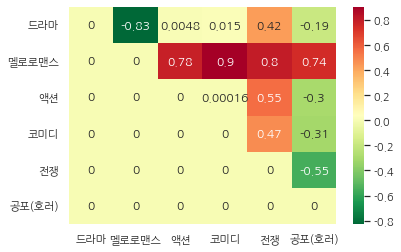

In [41]:
import numpy as np; 
import seaborn as sns; 

np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 

plt.rcParams['axes.unicode_minus'] = False

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax

## 6-8. 프로젝트 : 모든 장르 간 편향성 측정해 보기
> 영화 구분과 모든 영화 장르간에 내재된 편향성 측정

## STEP 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기

#### sysnopsis.txt로 부터 품사가 명사인 경우만 tokenized에 저장

In [42]:
# 약 15분정도 걸립니다.
import os
from konlpy.tag import Okt
okt = Okt()
tokenized = []
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)

print("슝~")

슝~


In [43]:
len(tokenized)
tokenized[:5]

71156

[['사운드', '엔지니어', '상우', '유지태', '분', '치매', '할머니', '백성희', '분'],
 ['시절', '상처', '아버지', '박인환', '분', '고모', '신신애', '분', '살'],
 ['겨울', '그', '지방', '방송국', '라디오', '은수', '이영애', '분', '를'],
 ['자연', '소리', '채집', '라디오', '프로그램', '준비', '은수', '상우', '녹음', '여행'],
 ['두', '사람', '날', '은수', '아파트', '밤']]

## STEP 2. 추출된 결과로 embedding model 만들기

In [44]:
from gensim.models import Word2Vec

# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  

# Gensim 3.X 에서는 아래와 같이 생성합니다. 
# model = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=0)  

In [45]:
model.wv.most_similar(positive=['영화'])
model.wv.most_similar(positive=['사랑'])
model.wv.most_similar(positive=['연극'])

[('작품', 0.9001291990280151),
 ('다큐멘터리', 0.8548182249069214),
 ('드라마', 0.8408967852592468),
 ('영화로', 0.837256669998169),
 ('형식', 0.8048837780952454),
 ('개연', 0.7953914999961853),
 ('코미디', 0.7927410006523132),
 ('감동', 0.7918827533721924),
 ('소재', 0.790608286857605),
 ('스토리', 0.7894114851951599)]

[('진심', 0.7029464244842529),
 ('첫사랑', 0.6965757608413696),
 ('행복', 0.6938179135322571),
 ('만남', 0.6911566257476807),
 ('운명', 0.6895471215248108),
 ('우정', 0.6831419467926025),
 ('애정', 0.682773768901825),
 ('연애', 0.6766237616539001),
 ('상처', 0.6706485748291016),
 ('감정', 0.6614930629730225)]

[('시나리오', 0.9001540541648865),
 ('영화감독', 0.8935526609420776),
 ('영감', 0.8911793828010559),
 ('데뷔', 0.8846921920776367),
 ('각색', 0.876941442489624),
 ('배우', 0.8731455206871033),
 ('연기자', 0.8715932369232178),
 ('캐스팅', 0.870272696018219),
 ('대본', 0.868678867816925),
 ('예술', 0.866378903388977)]

## STEP 3. target, attribute 단어 셋 만들기

* synopsis_art.txt', 'synopsis_gen.txt' 두 파일을 읽기
* 명사만 추출하여 art, gen 변수에 할당

In [70]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt

art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)


In [47]:
# 2개의 파일을 처리하는데 10분 가량 걸립니다. 
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [71]:
len(art)
len(gen)

620208

3014815

#### Target 단어 셋 

> 영화구분   
> Target_X : art  
> Target_Y : general

In [48]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


In [49]:
print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names()[23976])

23976
영화


In [50]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

#### 상위 100개 단어들 중 중복되는 단어 제외하고 상위15개 추출

In [51]:
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

In [52]:
print(target_art)
print(target_gen)

['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']
['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


#### Attribute 단어셋 
* 장르별 대표 단어 추출

In [53]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [54]:
# 약 10분정도 걸립니다.
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [55]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 42191)


In [56]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 
기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 
다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 
드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 
뮤지컬: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 페뷔스, 
미스터리: 사건, 그녀, 시작, 자신, 위해, 사람, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 남자, 
범죄: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 
사극: 조선, 위해, 시작, 신기전, 사랑, 자신, 아가멤논, 황제, 그녀, 루안, 최고, 운명, 사람, 하선, 전쟁, 
서부극(웨스턴): 서부, 보안관, 위해, 벌린, 카우보이, 그레이프바인, 헨리, 마을, 자신, 개릿, 아이, 시작, 무법자, 프린트, 마적, 
성인물(에로): 그녀, 남편, 마사지, 자신, 섹스, 관계, 영화, 정사, 남자, 위해, 시작, 여자, 유부녀, 마음, 사랑, 
스릴러: 자신, 그녀, 사건, 

## STEP 4. WEAT score 계산과 시각화

* 영화 구분, 영화 장르에 따른 편향성을 측정하여 WEAT score로 계산해 보고 이를 Heatmap 형태로 시각화
* 편향성이 두드러지는 영화장르 attribute 구성에는 어떤 케이스가 있는지 시각적으로 두드러지게 구성

* X = 예술영화(art)
* Y = 일반영화(gen)  


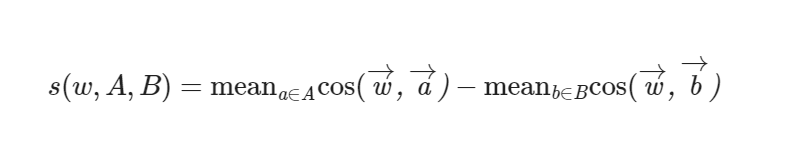

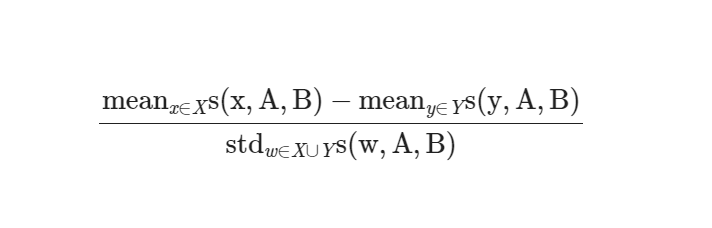

In [69]:
Image(filename='s.png') 
Image(filename='weat_score.png') 

In [74]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [80]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [81]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])

SF 가족 -0.49271214
SF 공연 -0.38479036
SF 공포(호러) -0.6684208
SF 기타 0.3369339
SF 다큐멘터리 0.5710849
SF 드라마 -0.37180683
SF 멜로로맨스 -0.7864046
SF 뮤지컬 0.33296397
SF 미스터리 -0.6807212
SF 범죄 -0.23329894
SF 사극 -0.8305285
SF 서부극(웨스턴) -0.43043423
SF 성인물(에로) -0.5745926
SF 스릴러 -0.5221983
SF 애니메이션 0.35209507
SF 액션 -0.4377844
SF 어드벤처 -0.78089696
SF 전쟁 0.20468955
SF 코미디 -0.44147357
SF 판타지 -0.18104038
가족 공연 0.16113189
가족 공포(호러) -0.17109253
가족 기타 0.72451323
가족 다큐멘터리 0.8021763
가족 드라마 0.2015392
가족 멜로로맨스 -0.6293828
가족 뮤지컬 0.67521864
가족 미스터리 -0.31830165
가족 범죄 0.19055374
가족 사극 -0.103462294
가족 서부극(웨스턴) 0.35951713
가족 성인물(에로) -0.34096017
가족 스릴러 -0.15811914
가족 애니메이션 0.83163494
가족 액션 0.10181001
가족 어드벤처 -0.054906514
가족 전쟁 0.6248422
가족 코미디 0.1864347
가족 판타지 0.4123713
공연 공포(호러) -0.23323421
공연 기타 0.9018858
공연 다큐멘터리 0.90032923
공연 드라마 0.02531057
공연 멜로로맨스 -0.68822646
공연 뮤지컬 0.86109734
공연 미스터리 -0.34561884
공연 범죄 0.07707789
공연 사극 -0.36636811
공연 서부극(웨스턴) 0.032236643
공연 성인물(에로) -0.48001873
공연 스릴러 -0.21423456
공연 애니메이션 0.89382493
공연 액션 

<Figure size 1440x1440 with 0 Axes>

<AxesSubplot:>

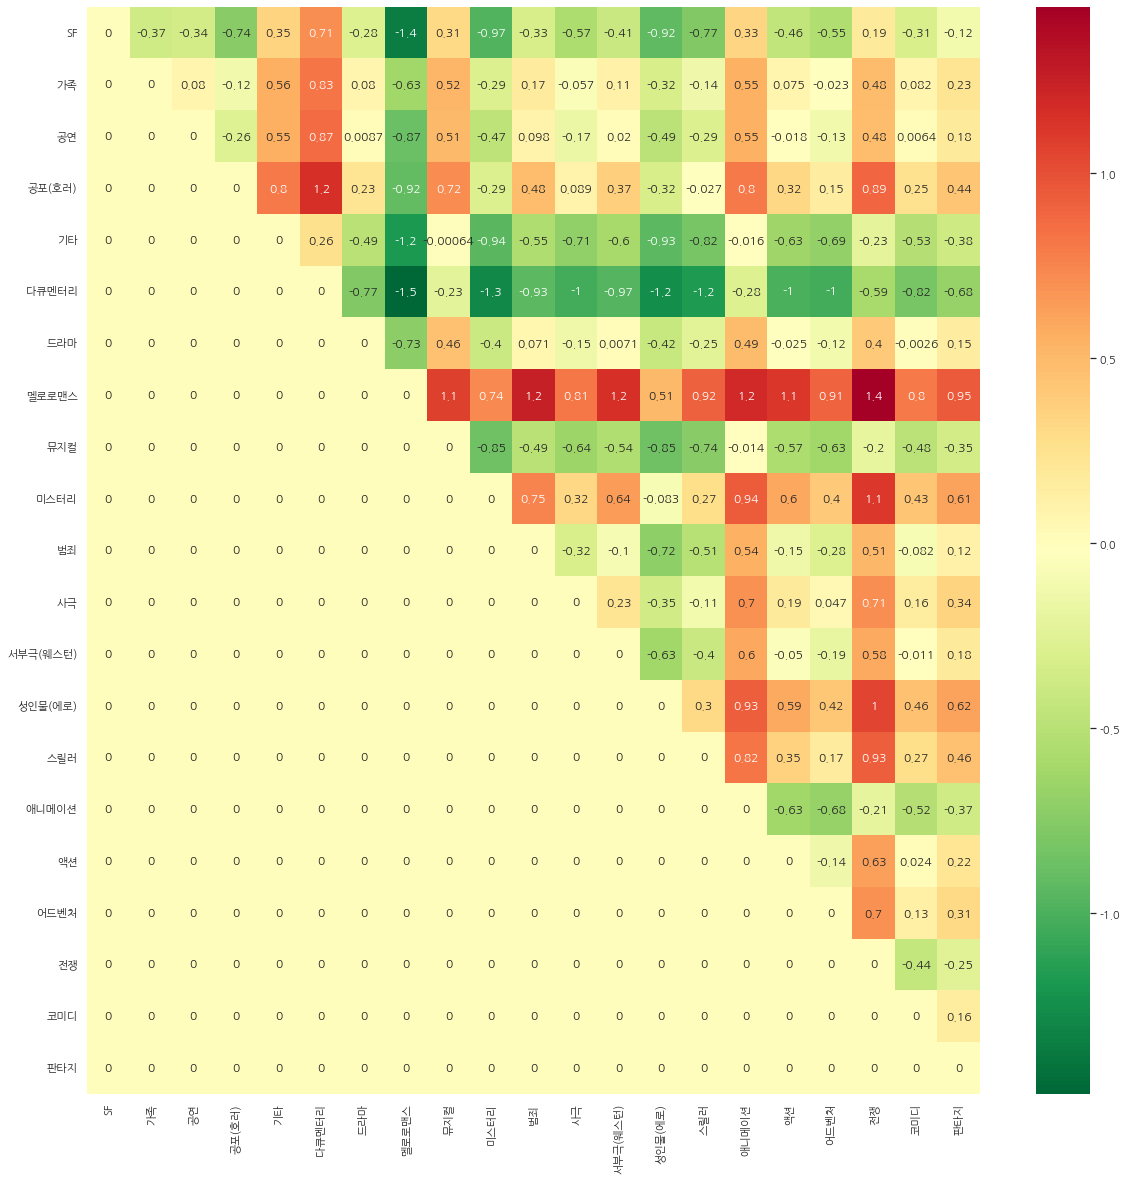

In [77]:
import numpy as np; 
import seaborn as sns; 

np.random.seed(0)

plt.figure(figsize=(20,20))
# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 

plt.rcParams['axes.unicode_minus'] = False

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax

#### WEAT score 0.8 이상 ( 부호가 +이므로 사람의 편향과 같음)

In [96]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if matrix[i][j] >= 0.8 : 
            print(genre_name[i], genre_name[j],matrix[i][j])

가족 다큐멘터리 0.8021763
가족 애니메이션 0.83163494
공연 기타 0.9018858
공연 다큐멘터리 0.90032923
공연 뮤지컬 0.86109734
공연 애니메이션 0.89382493
드라마 애니메이션 0.8588032
멜로로맨스 뮤지컬 0.8387149
멜로로맨스 범죄 0.8363175
멜로로맨스 애니메이션 0.85699844
멜로로맨스 코미디 0.89184076
멜로로맨스 판타지 0.8211771
미스터리 범죄 0.9876824
사극 애니메이션 0.8211613
사극 전쟁 0.8586076


|예술영화|일반영화|편향|weat score|
|:---------:|:----------:|:----------:|:--:|
|가족|다큐멘터리|같음|0.80 |
|가족|애니메니션|같음|0.83 |
|공연|기타|같음| 0.90|
|공연|다큐멘터리|같음|0.90 |
|공연|뮤지컬|같음|0.86 |
|공연|애니메이션|같음|0.89 |
|드라마|매니메이션|같음|0.85 |
|멜로로맨스|뮤지컬|같음|0.83 |
|멜로로맨스|범죄|같음|0.83 |
|멜로로맨스|애니메이션|같음|0.85 |
|멜로로맨스|코미디|같음|0.89 |
|멜로로맨스|판타지|같음|0.82 |
|미스터리|범죄|같음|0.98 |
|사극|애미메이션|같음|0.82 |
|사극|전쟁|같음|0.85 |

#### WEAT score - 0.8 이하 ( 부호가 -이므로 사람의 편향과 반대임)

In [94]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if matrix[i][j] <= -0.8 : 
            print(genre_name[i], genre_name[j],matrix[i][j])

SF 사극 -0.8305285
기타 드라마 -0.85781413
기타 멜로로맨스 -0.8704546
기타 사극 -0.8095894
기타 성인물(에로) -0.80475205
다큐멘터리 드라마 -0.8835549
다큐멘터리 멜로로맨스 -0.87523586
다큐멘터리 사극 -0.8793625
다큐멘터리 성인물(에로) -0.8179707
다큐멘터리 어드벤처 -0.92290896
다큐멘터리 판타지 -0.86301374
드라마 멜로로맨스 -0.82414144
범죄 스릴러 -0.97473246
애니메이션 어드벤처 -0.87322026


|예술영화|일반영화|편향|weat score|
|:---------:|:----------:|:----------:|:--:|
|사극|SF|반대|-0.83 |
|드라마|기타|반대|-0.85 |
|멜로로맨스|기타|반대| -0.87|
|사극|기타|반대|-0.80 |
|성인물|기타|반대|-0.88 |
|드라마|다큐멘터리|반대|-0.87 |
|멜레로맨스|타큐멘터리|반대|-0.87 |
|사극|다큐멘터리|반대|-0.81 |
|성인물|다큐멘터리|반대|-0.92 |
|에드밴처|다큐멘터리|반대|-0.86 |
|판타지|드라마|반대|-0.82 |
|멜로로맨스|판타지|반대|-0.97 |
|스릴러|범죄|반대|0.98 |
|애니메이션|애미메이션|반대|-0.87 |

## 회고 